# Calculating kappa-0 from Noise data per station

### IMPORT TRACE PER STATION PER DAY (Noise cutted : FIRST 5 MINUTES A DAY)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mtspec import mtspec
import scipy
import pandas as pd 
from obspy.signal.filter import bandpass
from obspy import read, read_inventory
import warnings
warnings.simplefilter("ignore", UserWarning)

# !conda install -c anaconda seaborn -y
# from obspy.signal.konnoohmachismoothing import (
# konno_ohmachi_smoothing as konnoohmachi)

def nextpow2(n): 
    count = 0; 
#if n is already a power of 2, return n immediately
    if (n and not(n & (n - 1))): 
        return n 
# this logic below only works if n is not already a power of 2   
    while( n != 0): 
        n >>= 1
        count += 1     
    return 1 << count


def PSD_AMP(sig,_sigpsd,fsig):
    sig_amp = np.sqrt((_sigpsd*len(fsig))/sig.stats['sampling_rate'])
    return sig_amp

def FAS_PSD_func (tr,nfft, smoothing=None,
                  smoothing_count=1, smoothing_constant=40):
    from konno_ohmachi_smoothing import calculate_smoothing_matrix
#     nfft  = nextpow2(len(tr.data))
    norm = len(tr.data)
    nfft = nextpow2(nfft)
    npositive = nfft//2
    pslice = slice(1, npositive)
    freq_sig_ = np.fft.fftfreq(nfft, d=1/tr.stats['sampling_rate'])[pslice] 
    sig_psd_ = (np.abs((np.fft.fft(tr.data,n =nfft)[pslice]))**2)
    sig_amp_= PSD_AMP(tr,sig_psd_,freq_sig_)
    
     # Apply smoothing.
    if smoothing:
        if 'konno-ohmachi' in smoothing.lower():
            
            sm_matrix = calculate_smoothing_matrix(freq_sig_,smoothing_constant)
                
            for _j in range(smoothing_count):
                smooth_fas = np.dot(sig_amp_, sm_matrix)
                        
    return freq_sig_, sig_amp_, sig_psd_,smooth_fas

def gradient (low, up, spec, freq):
    # find where low freq, first index
    i_low = np.where(np.round(freq)== low)[0][0] 
    # find where upper freq, last index
    i_up = np.where(np.round(freq)== up)[0][-1]
    # cut the data from i_low to i_up
    x = freq [i_low: i_up ]
    y = spec [i_low: i_up ]
    coef = np.polyfit(x, y, 1)
    poly1d = np.poly1d(coef)
    return coef,poly1d, x, y 

def kappa(gradient_coef):
    m = gradient_coef
    return -m/(2*np.pi)


In [2]:
# set the distances for the stream (required for theoreticals)
import specmod.PreProcess as pre
import specmod.utils as ut
def set_distances (event):
    import numpy as np
    from obspy import UTCDateTime
    import pandas as pd
    file_ ="/Users/psuroyo/Documents/Study_DataWork/ModerateBigEvents.xlsx"
    s= pd.read_excel(file_,sheet_name='Sheet2')

    for i,var in enumerate(s['Date']):
        #events_id = str(var).split(' ')[0]+'T'+str(str(s['time'][i]).split(' ')[1])
        events_id = str(var).split(' ')[0]+'T'+str(s['time'][i])
        if event == events_id:
            olat_    = s['lat'][i]
            olon_    = s['lon'][i]
            odep     = s['depth'][i]
            ML_      = s['ML'][i]
            return np.float(olat_), np.float(olon_), np.float(odep), UTCDateTime(events_id), np.float(ML_)

def Earthquake_kappa(path_e, sta, flow, fup, nfft):
    pinv  = "/Users/psuroyo/Documents/Study_DataWork/PNR_TLS_Array/selected_mseed_p/Inventory/"
    inv = read_inventory(os.path.join(pinv,'pnr_inventory.xml'),'stationxml')

    pdata= os.path.join(path_e,sta)
    stE, stN = read(os.path.join(pdata, '*HHE*'), format='mseed'), read(os.path.join(pdata, '*HHN*'), format='mseed')
    stZ = read(os.path.join(pdata, '*HHZ*'), format='mseed')
    st = stE + stN+ stZ
    olat, olon, odep, otime, ML = set_distances  ("2019-08-26T07:30:47.0")
    pre.set_stream_distance(st, olat, olon, odep, otime, inventory=inv, dtype="mseed")

    # set the picks
    pre.set_picks_from_pyrocko(st, os.path.join(path_e, "2019-08-26T07:30:47.0"+"00000_pick"))
    
    ut.plot_traces(st.copy(), plot_theoreticals=True, conv=1)
    # remove the traces with no p-pick, for s and coda spectra fitting, remove traces without s-pick
    for tr in st:
        try:
            tr.stats['p_time']
            tr.stats['s_time']
        except KeyError:
                st.remove(tr)



    for i, tr in enumerate (st):
        tr.stats['Ml']= ML
        tr.id= tr.stats.network +'.'+tr.stats.station +'..'+tr.stats.channel
        tr.remove_response(inv, pre_filt=[0.05,0.1,40,45],output='VEL')
        f, fas, psd,smooth= FAS_PSD_func (tr,nfft,smoothing='konno-ohmachi',smoothing_count=1, smoothing_constant=40)
        coef,poly1d, new_x, new_y = gradient (flow, fup, np.log(smooth), f)

        if i == 0:
            E_smooth = smooth
            gradE=coef[0]
            cE=coef[1]
        if i == 1:
            N_smooth = smooth
            gradN = coef[0]
            cN = coef[1]
        if i == 2:
            Z_smooth = smooth
            gradZ= coef[0]
            cZ = coef[1]


    hvsr = np.sqrt(pow(E_smooth,2) + pow(N_smooth,2))/Z_smooth


    coefE,poly1E, x_E, yE = gradient (flow, fup, np.log(E_smooth), f)
    coefN,poly1N, x_N, yN = gradient (flow, fup, np.log(N_smooth), f)
    coefZ,poly1Z, x_Z, yZ = gradient (flow, fup, np.log(Z_smooth), f)
    amp=[E_smooth,N_smooth,Z_smooth]  
    x=[x_E,x_N,x_Z]
    poly= [poly1E,poly1N, poly1Z]
    freq=[f,f,f]
    coef = [coefE,coefN,coefZ]
    return freq, amp, x, poly, coef

Text(0.5, 0.98, 'LV.L003')

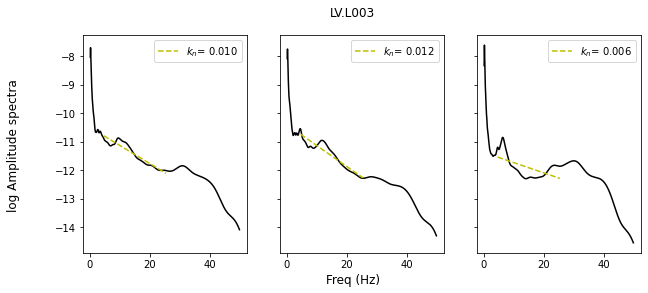

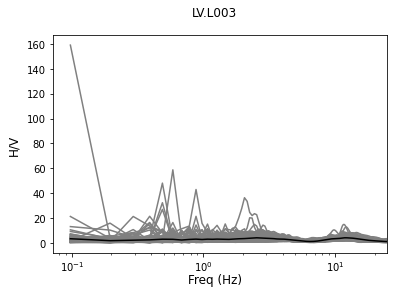

In [11]:
direc='/Users/psuroyo/Downloads/Noise/'
yearl= ['2018']
net= 'LV'
sta= 'L003'
pinv  = "/Users/psuroyo/Documents/Study_DataWork/PNR_TLS_Array/selected_mseed_p/Inventory/"
inv = read_inventory(os.path.join(pinv,'pnr_inventory.xml'),'stationxml')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(10,4))
fig2, bx = plt.subplots()
highpass_value = 2 
lowpass_value = 48
flow = 5
fup = 25
store_hvsr=[]
store_ampE=[];store_ampN=[];store_ampZ=[]
gradE=[];gradN=[]; gradZ=[]
cE=[];cN=[];cZ=[]
nfft=1000
for year in yearl:
    path = os.path.join(direc,year,net,sta)
    list_ev = [f for f in os.listdir(path) if not f.startswith('.')]
    for ev in list_ev:
        list_rec = [f for f in os.listdir(os.path.join(path,ev)) if not f.startswith('.')]
        if len(list_rec)==3:
            stE, stN = read(os.path.join(path,ev, '*HHE*'), format='mseed'), read(os.path.join(path,ev, '*HHN*'), format='mseed')
            hor = stE+ stN
            ver = read(os.path.join(path,ev, '*HHZ*'), format='mseed')

            for tr in stE:
                tr.remove_response(inv, output='VEL',pre_filt=[0.05,0.1,40,45], zero_mean=True, taper=True, taper_fraction=0.05)
                E_f, E_fas, E_psd,E_smooth= FAS_PSD_func (tr,nfft,smoothing='konno-ohmachi',smoothing_count=1, smoothing_constant=40)
                coefE,poly1dE, new_xE, new_yE = gradient (flow, fup, np.log(E_smooth), E_f)
                gradE.append(coefE[0])
                cE.append(coefE[1])
                store_ampE.append(E_smooth)
#                 ax1.plot (E_f,np.log(E_smooth),'grey')
#                 ax1.set_title('E-comp')
        #         ax.plot( new_xE, poly1dE(new_xE), '--y')
            for tr in stN:
                tr.remove_response(inv, output='VEL',pre_filt=[0.05,0.1,40,45], zero_mean=True, taper=True, taper_fraction=0.05)
                N_f, N_fas, N_psd,N_smooth= FAS_PSD_func (tr,nfft,smoothing='konno-ohmachi',smoothing_count=1, smoothing_constant=40)
                coefN,poly1dN, new_xN, new_yN = gradient (flow, fup, np.log(N_smooth), N_f)
                gradN.append(coefN[0])
                cN.append(coefN[1])
                store_ampN.append(N_smooth)
#                 ax2.plot (N_f,np.log(N_smooth),'grey')
#                 ax2.set_title('N-comp')
        #         ax.plot( new_xN, poly1dN(new_xN), '--y')

            for tr in ver:
                tr.remove_response(inv, output='VEL',pre_filt=[0.05,0.1,40,45], zero_mean=True, taper=True, taper_fraction=0.05)
        #         tr.normalize()  
                Z_f, Z_fas, Z_psd,Z_smooth= FAS_PSD_func (tr,nfft,smoothing='konno-ohmachi',smoothing_count=1, smoothing_constant=40)
                coefZ,poly1dZ, new_xZ, new_yZ = gradient (flow, fup, np.log(Z_smooth), Z_f)
                gradZ.append(coefZ[0])
                cZ.append(coefZ[1])
                store_ampZ.append(Z_smooth)
#                 ax3.plot (Z_f,np.log(Z_smooth),'grey')
#                 ax3.set_title('Z-comp')
        #         ax.plot( new_xZ, poly1dZ(new_xZ), '--y')



            hvsr = np.sqrt(pow(E_smooth,2) + pow(N_smooth,2))/Z_smooth
            store_hvsr.append(hvsr)
            bx.plot (Z_f,hvsr,'grey')
            bx.set_xscale('log')
            bx.set_xlim(0,max(Z_f)/2)


ampE = np.mean(store_ampE, axis=0);coefE,poly1E, x_E, yE = gradient (flow, fup, np.log(ampE), E_f)
ampN = np.mean(store_ampN, axis=0);coefN,poly1N, x_N, yN = gradient (flow, fup, np.log(ampN), N_f)
ampZ = np.mean(store_ampZ, axis=0);coefZ,poly1Z, x_Z, yZ = gradient (flow, fup, np.log(ampZ), Z_f)
ax1.plot (E_f,np.log(ampE),'k');ax1.plot( x_E, poly1E(x_E), '--y', label="$k_{n}$= "+"{:.3f}".format(kappa(coefE[0])))
ax2.plot (N_f,np.log(ampN),'k');ax2.plot( x_N, poly1N(x_N), '--y', label="$k_{n}$= "+"{:.3f}".format(kappa(coefN[0])))
ax3.plot (Z_f,np.log(ampZ),'k');ax3.plot( x_Z, poly1Z(x_Z), '--y', label="$k_{n}$= "+"{:.3f}".format(kappa(coefZ[0])))

# path_eq = "/Volumes/Samsung_T5/2019-08-26T07:30:47.0"

# fe, ampe, xe, polye, coefe = Earthquake_kappa(path_eq, sta, flow, fup, nfft)

# ax1.plot (fe[0],np.log(ampe[0]),'b');ax1.plot( xe[0], polye[0](xe[0]), '--r', label="$k_{2.9 ML}$= "+"{:.3f}".format(kappa(coefe[0][0])))
# ax2.plot (fe[1],np.log(ampe[1]),'b');ax2.plot( xe[1], polye[1](xe[1]), '--r', label="$k_{2.9 ML}$= "+"{:.3f}".format(kappa(coefe[1][0])))
# ax3.plot (fe[2],np.log(ampe[2]),'b');ax3.plot( xe[2], polye[2](xe[2]), '--r', label="$k_{2.9 ML}$= "+"{:.3f}".format(kappa(coefe[2][0])))

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

fig.supylabel("log Amplitude spectra")
fig.supxlabel("Freq (Hz)")
fig.suptitle(net+'.'+sta)


hvsr_avg=np.mean(store_hvsr, axis=0)
bx.plot (Z_f,hvsr_avg,'k')
# bx.set_ylim(0,3)
fig2.supylabel('H/V')
fig2.supxlabel("Freq (Hz)")
fig2.suptitle(net+'.'+sta)



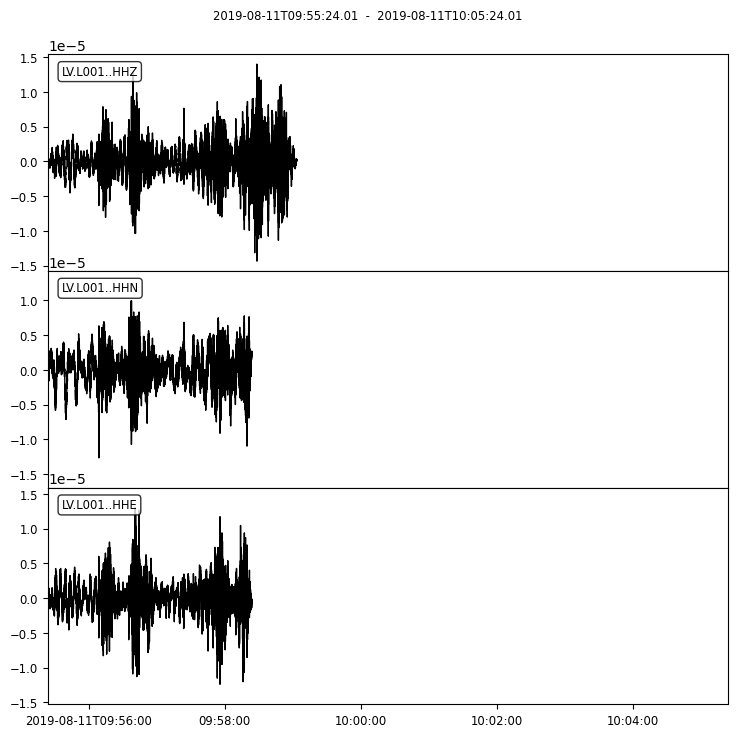

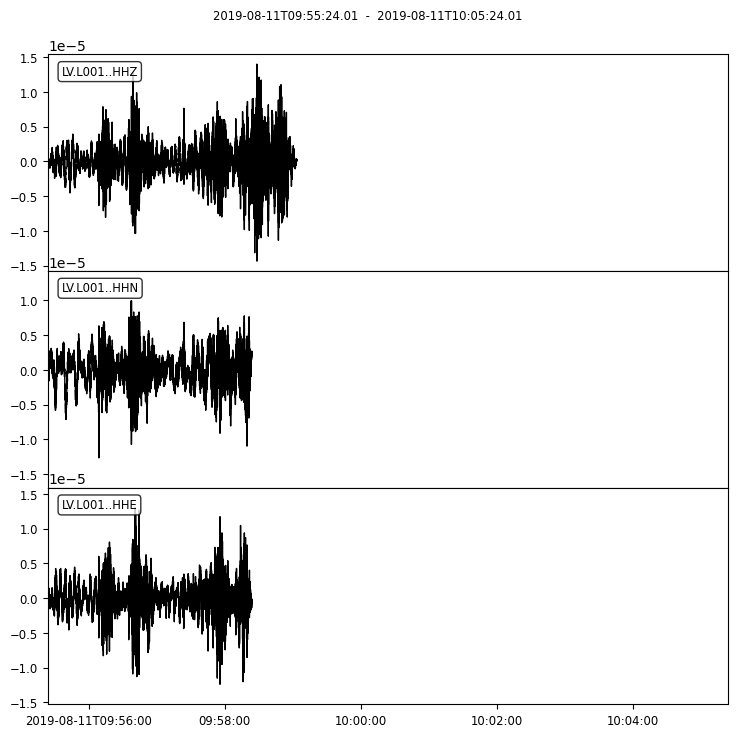

In [4]:
s= hor+ ver

for t in s:
    t.trim(starttime=t.stats.starttime, endtime=t.stats.starttime+600, pad=True)
s.plot()


In [5]:
tr.stats

         network: LV
         station: L001
        location: 
         channel: HHZ
       starttime: 2019-08-11T09:55:24.010000Z
         endtime: 2019-08-11T10:05:24.010000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 60001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 108, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 55296})
      processing: ["ObsPy 1.2.2: remove_response(fig=None::inventory=<obspy.core.inventory.inventory.Inventory object at 0x7fe4bc89a2d0>::output='VEL'::plot=False::pre_filt=[0.05, 0.1, 40, 45]::taper=True::taper_fraction=0.05::water_level=60::zero_mean=True)", 'ObsPy 1.2.2: trim(endtime=UTCDateTime(2019, 8, 11, 10, 5, 24, 10000)::fill_value=None::nearest_sample=True::pad=True::starttime=UTCDateTime(2019, 8, 11, 9, 55, 24, 10000))']

/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Future

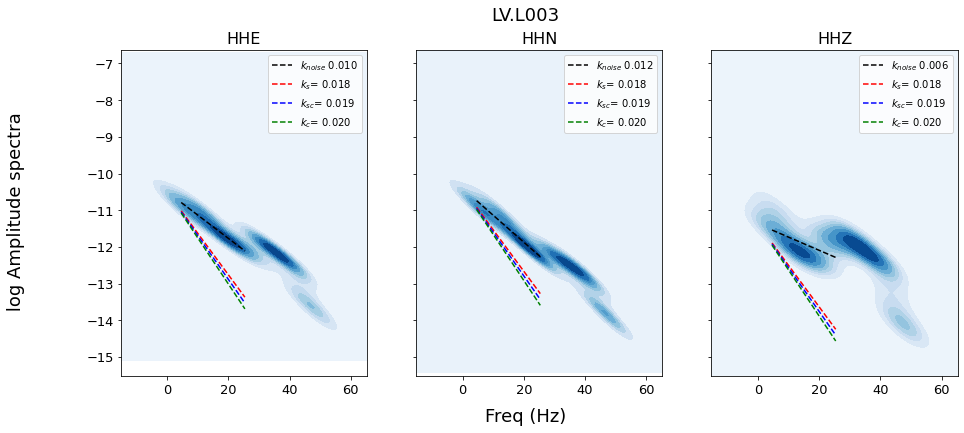

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

ch =['HHE','HHN','HHZ']
c=[coefE,coefN,coefZ]
f=[E_f,N_f,Z_f]
x= [x_E,x_N,x_Z]
amp=[ampE,ampN,ampZ]

fig,ax = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(net+'.'+sta,fontsize=18)
# plt.ylim(-6.5,-3.5)
for i in range (len(ax)):
        pols=np.poly1d([-0.018 *(2*np.pi),c[i][1]])
        polsc=np.poly1d([-0.019*(2*np.pi),c[i][1]])
        polc=np.poly1d([-0.020*(2*np.pi),c[i][1]])
        ax[i].set_title(str(ch[i]), fontsize = 16)
        ax[i].tick_params(labelsize=13)
        ploy1= np.poly1d([c[i][0],c[i][1]])
        sns.kdeplot(f[i], np.log(amp[i]), cmap="Blues", shade=True, thresh=0,ax=ax[i])
        ax[i].plot(x[i], (ploy1(x[i])),'--k', label='$k_{noise}$ '+"{:.3f}".format(abs(c[i][0])/(2*np.pi)))
#         ax[i].plot( xe[i], polye[0](xe[0]),'--y', 
#                    label="$k_{2.9 ML}$= "+"{:.3f}".format(kappa(coefe[i][0])))
        ax[i].plot(x[i], (pols(x[i])),'--r',label='$k_{s}$= 0.018')
        ax[i].plot(x[i], (polsc(x[i])),'--b',label='$k_{sc}$= 0.019')
        ax[i].plot(x[i], (polc(x[i])),'--g',label='$k_{c}$= 0.020')
        
#         ax[i].plot(x[i], (ploy1m(x[i])),'-.k',alpha=0.3,label='k= '+"{:.3f}".format(k[0])+"+/-"+"{:.4f}".format(k[1]))
        ax[i].legend(loc='upper right')
        
fig.supylabel(" log Amplitude spectra",fontsize=18)
fig.supxlabel("Freq (Hz)",fontsize=18)
fig.savefig(os.path.join(direc,str(net)+'.'+str(sta)+".png"),dpi=300)
plt.show()


In [11]:
c[i][1]/(2*np.pi)

-0.0091792712093764339

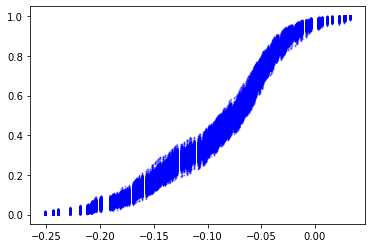

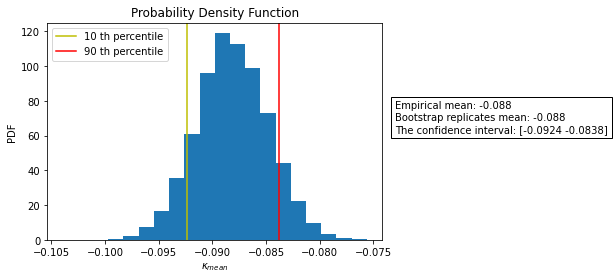

In [17]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample) 
    return bs_replicates

# Create a function to get x, y for of ecdf
def get_ecdf(data):
    
    # Get lenght of the data into n
    n = len(data)
    
    # We need to sort the data
    x = np.sort(data)
    
    # the function will show us cumulative percentages of corresponding data points
    y = np.arange(1,n+1)/n
    
    return x,y

def resampling(data,size,repetition=0.2):
    import random
    # Create an empty array to store replicates
    bs_sample = np.empty(size)
    k_repetition = int(round(repetition* len(data)))
    k_retention = int(round((1-repetition)* len(data)))
    #Generate n samples from a sequence with the possibility of repetition. 
    bs_repetition = random.choices(data,k=k_repetition) 
    #Generate n unique samples (multiple items) from a sequence without repetition a.k.a retention
    bs_retention = random.sample(list(data),k=k_retention)
    
    bs_sample = np.concatenate((bs_repetition, bs_retention), axis=None)
    # check length output
    if len(bs_sample)!= size:
        print('check size')
    else:
        return bs_sample
def bootstrap (grad):
    for i in range(1000):

        # Generate a bootstrap sample
        bs_sample_ = np.random.choice(np.asarray(grad),size=len(np.asarray(grad)))

        # Plot ecdf for bootstrap sample
        x, y = get_ecdf(bs_sample_)
        plt.scatter(x, y,s=1,c='b',alpha=0.3)

    plt.show()

    # Draw 10000 bootstrap replicates
    bs_replicates_ = draw_bs_replicates(np.asarray(grad),np.mean,15000)
    conf_interval = np.percentile(bs_replicates_,[10,90])
    emp = np.mean(np.asarray(grad))
    # Plot probability density function
    plt.hist(bs_replicates_,bins=20,density=True)
    plt.axvline(x=np.percentile(bs_replicates_,[10]), ymin=0, ymax=1,label='10 th percentile',c='y')
    plt.axvline(x=np.percentile(bs_replicates_,[90]), ymin=0, ymax=1,label='90 th percentile',c='r')
    side_text = plt.figtext(0.93, 0.5, "Empirical mean: " + str(round(emp,3))
                            +'\n'+"Bootstrap replicates mean: " + str(round(np.mean(bs_replicates_),3))
                            +'\n'+"The confidence interval: "+ str(np.around(conf_interval,4)), bbox=dict(facecolor='white'))

    plt.xlabel(r"$ \kappa_{mean}$")
    plt.ylabel("PDF")
    plt.title("Probability Density Function")
    plt.legend()
    plt.show()

bootstrap (gradE)


In [42]:
np.mod(np.asarray(gradE))

TypeError: remainder() takes from 2 to 3 positional arguments but 1 were given

In [24]:
print(coefE)

[-0.01740982 -5.47256709]


/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Future

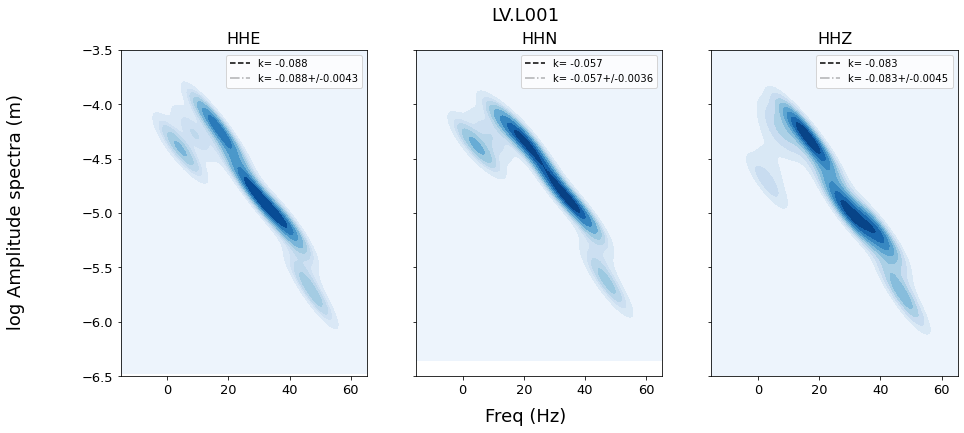

In [18]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def meanstd_k (grad,c): 
    k   = mean_confidence_interval((np.asarray(grad)), confidence=0.80)
    coe = mean_confidence_interval((np.asarray(c)), confidence=0.80)
    ploy1 = np.poly1d([k[0],coe[0]])
    ploy1p= np.poly1d([k[0]+k[1],coe[0]+coe[1]])
    ploy1m= np.poly1d([k[0]-k[1],coe[0]-coe[1]])
    
    return k,coe, ploy1, ploy1p, ploy1m

import seaborn as sns
import matplotlib.pyplot as plt

ch =['HHE','HHN','HHZ']
grad=[gradE, gradN, gradZ]
c=[cE,cN,cZ]
f=[E_f,N_f,Z_f]
x= [new_xE,new_xN,new_xZ]
amp=[ampE,ampN,ampZ]

fig,ax = plt.subplots(1, 3, figsize=(15,6), sharey=True)
fig.suptitle(net+'.'+sta,fontsize=18)
plt.ylim(-6.5,-3.5)
for i in range (len(ax)):
        ax[i].set_title(str(ch[i]), fontsize = 16)
        ax[i].tick_params(labelsize=13)
        k,coef, ploy1, ploy1p, ploy1m = meanstd_k (grad[i],c[i])
        sns.kdeplot(f[i], np.log10(amp[i]), cmap="Blues", shade=True, thresh=0,ax=ax[i])
        ax[i].plot(x[i], (ploy1(x[i])),'--k', label='k= '+"{:.3f}".format(k[0]))
        ax[i].plot(x[i], (ploy1p(x[i])),'-.k',alpha=0.3)
        ax[i].plot(x[i], (ploy1m(x[i])),'-.k',alpha=0.3,label='k= '+"{:.3f}".format(k[0])+"+/-"+"{:.4f}".format(k[1]))
        ax[i].legend(loc='upper right')
        
fig.supylabel(" log Amplitude spectra (m)",fontsize=18)
fig.supxlabel("Freq (Hz)",fontsize=18)
plt.show()


In [9]:
len(list_rec)

1

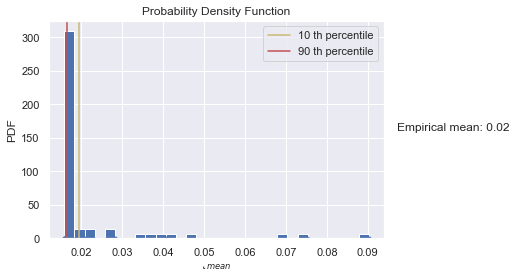

In [50]:


def plot_ecdf(data,labelx,labely,title,color):
    """Plot ecdf"""
    # Call get_ecdf function and assign the returning values
    x, y = get_ecdf(data)
    
    plt.plot(x,y,marker='.',linestyle='none',c=color)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(title)
    
import numpy as np
import scipy.stats



    
plot_ecdf(abs(np.asarray(grad[0])),"labelx","labely",net+'.'+sta+str(ch[0]),'b')


# Plot probability density function
plt.hist(abs(np.asarray(grad[0])),bins=30,density=True)
plt.axvline(x=np.percentile(abs(np.asarray(grad[0])),[80]), ymin=0, ymax=1,label='10 th percentile',c='y')
plt.axvline(x=np.percentile(abs(np.asarray(grad[0])),[20]), ymin=0, ymax=1,label='90 th percentile',c='r')
side_text = plt.figtext(0.93, 0.5, "Empirical mean: " + str(round(np.mean(abs(np.asarray(grad[0]))),2)), bbox=dict(facecolor='white'))

plt.xlabel(r"$ \k_{mean}$")
plt.ylabel("PDF")
plt.title("Probability Density Function")
plt.legend()
plt.show()